In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('input.csv', index_col=False)

data.head()

,event,particle,hit,x,y
0,0,10000100,100000640,247.365072,968.954400
1,0,10000100,100000830,494.712256,1937.881317
2,0,10000100,100001150,742.059440,2906.808234
3,0,10000100,100000010,989.406625,3875.735151
4,0,10000100,100000560,1236.753809,4844.662068


# Hough Transform

Consider a track pattern recognition method using the Hough Tramsform in polar system. In this system a circular track can be parametrized as follow:

$$
r = 2r_{0}Cos(\phi - \theta)
$$

where:
* $r$ and $\phi$ : are coordinates of a hit in the polar system.
* $r_{0}$ and $\theta$ : are coordinates of a center of a circular track in the polar system.

A linear track corresponds to the $r_{0} = \infty$.

Transformation of cartesian coordinates of a hit to polar coordinates defined as:

$$
\phi = arctan(\frac{y}{x})
$$
$$
r = \sqrt{x^{2} + y^{2}}
$$


The Hough Transform converts a hit in $(r, \phi)$ space to a curve in $(\frac{1}{r_{0}}, \theta)$ space of the track parameters as follow:

$$
\frac{1}{r_{0}} = \frac{2Cos(\phi - \theta)}{r}
$$

A linear track in this space represents as $(0, \theta)$ point.

This section demonstrates the track pattern recognition method using Hough Transfrom described above and histogramming technique. 

## One event

In [3]:
toy_event_id = 0
event = data[data.event.values == toy_event_id]

In [4]:
%%time

from hough import Hough

h = Hough(n_theta_bins=500, n_radius_bins=500, min_radius=1500., min_hits=6)
h.predict(event.x.values, event.y.values)

matrix_hough = h.matrix_hough_
track_inds = h.track_inds_
track_params = h.track_params_

CPU times: user 67.4 ms, sys: 4.49 ms, total: 71.9 ms
Wall time: 82.1 ms


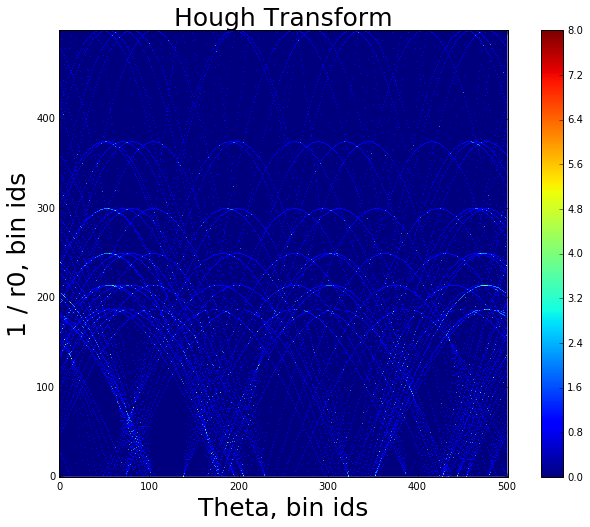

In [5]:
plt.figure(figsize=(12,8))
plt.imshow(matrix_hough.T, interpolation='none', origin='lower')
plt.title("Hough Transform", size=25)
plt.xlabel("Theta, bin ids", size=25)
plt.ylabel("1 / r0, bin ids", size=25)
plt.colorbar()
plt.show()

In [6]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([25, 26, 27, 28, 29, 30, 31]),
       array([17, 18, 19, 20, 21, 22, 23, 59]),
       array([106, 107, 108, 109, 110, 111]),
       array([ 96,  97,  98,  99, 100, 101, 102, 103]),
       array([50, 51, 52, 53, 54, 55])], dtype=object)

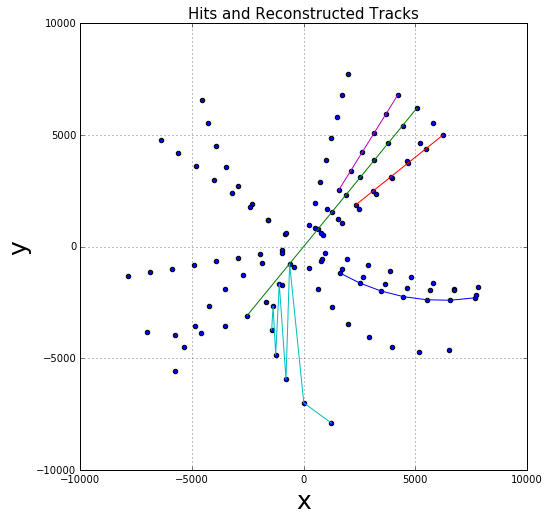

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(event.x.values, event.y.values)

for track in track_inds:
    
    xs = event.x.values[track]
    ys = event.y.values[track]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Reconstructed Tracks", size=15)
plt.xlabel("x", size=25)
plt.ylabel("y", size=25)
plt.grid(b=1)
plt.show()

In [8]:
track_params

array([[  8.31042546e-01,   1.09552438e-04],
       [  2.45535298e+00,   1.33600534e-06],
       [  5.38918499e+00,   1.33600534e-06],
       [  5.50250898e+00,   2.01736807e-04],
       [  5.72915694e+00,   1.33600534e-06]])

## Several events

**TrackRecognizer** is used to recognize tracks in several events using a track pattern recognition method. The method should has the following structure:

In [9]:
class Method(object):
    
    def __init__(self, params):
        
        # You code
        
        pass
    
    def predict(self, x, y):
        
        # Your code
        
        self.track_inds_

In [10]:
from recognizer import TrackRecognizer

method = Hough(n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=6)

tr = TrackRecognizer(method=method)
results = tr.predict(data)

results.head()

,event,track,hit,x,y
0,0,0,100001550,1251.738174,-2726.380667
1,0,0,100001190,2002.381957,-3462.725299
2,0,0,100001630,2911.944353,-4064.551647
3,0,0,100000530,3974.463771,-4494.845686
4,0,0,100000970,5182.237773,-4705.784915


## Quality metrics

Track recognition quality metrics described below are based on hit matching technique.

**Track Finding Efficiency** (or Track Efficiency) of a track is defined as:

$$
\epsilon = \frac{N_{reco\_true\_hits}}{N_{reco\_hits}}
$$

where:
* $N_{reco\_true\_hits}$ : is the number of recognized tru hits of the track.
* $N_{reco\_hits}$ : is the number of recognized hits of the track.

The track is considered to be reconstructed if its efficiency is higher than threshold, for example, 80%.

**Reconstruction Efficiency** of an event is defined as:

$$
\epsilon = \frac{N_{reco\_tracks}}{N_{tracks}}
$$

where:
* $N_{reco\_tracks}$ : is number of recognized tracks (without clones) of the event.
* $N_{tracks}$ : is total number of tracks in the event.

**Ghost Rate** is defined as:

$$
\epsilon = \frac{N_{ghost\_tracks}}{N_{tracks}}
$$

where:
* $N_{ghost\_tracks}$ : is number of ghost tracks which do not reconstruct any true particle.
* $N_{tracks}$ : is total number of tracks in the event.


A track recognition method can recognize track of a particle multiple times. Such redundant reconstructions are called clones.

**Clone Rate** is defined as:

$$
\epsilon = \frac{\sum_{m} N_{m\_track}^{clones}}{N_{tracks}}
$$

where:
* $N_{m\_track}^{clones}$ : is number of redundant reconstructions of the m-th track.
* $N_{tracks}$ : is total number of tracks in the event.

In [11]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data, results, track_eff_threshold=0.8, min_hits_per_track=6)
report_event, report_tracks = rq.calculate()

In [12]:
report_event.head()

,Event,ReconstructionEfficiency,GhostRate,CloneRate,AvgTrackEfficiency
0,0,1,0.333333,4.666667,0.949493
1,1,1,0.000000,4.166667,0.990975
2,2,1,0.571429,4.571429,0.929329
3,3,1,0.625000,4.937500,0.892649
4,4,1,1.928571,4.357143,0.858312


In [13]:
report_event.mean(axis=0)

Event                       99.500000
ReconstructionEfficiency     1.000000
GhostRate                    0.373114
CloneRate                    4.641422
AvgTrackEfficiency           0.952788
dtype: float64

In [14]:
report_tracks.head()

,Event,Track,TrackEfficiency
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
